In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import healpy as hp
from set_dataloader import CCD
import time
import pandas as pd
import random


#### Experimenting with input sizes

In [9]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


11.4 minutes (6.84e+02 seconds) taken to import the dict



In [ ]:
print(len(subpixel2ccd_dict))

In [3]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2subpixel_256_2048.pickle', 'rb') as f:
    pixel2subpixel_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


0.10516 minutes (6.31 seconds) taken to import the dict



In [ ]:
min = 1000
max = 0
aggregate = 0
index_max_sub = 0
lens = np.zeros(len(subpixel2ccd_dict))

for i, pix in enumerate(subpixel2ccd_dict.keys()):
    no_ccds = len(subpixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max_sub = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", max)
print("Min CCD's per subpixel:", min)



In [ ]:
plt.hist(lens, bins=[0, 30, 50, 100])
print("Pixels with more than 50 ccds:", (lens > 50).sum())
print("Pixels with more than 100 ccds:", (lens > 100).sum())
print("Pixels with more than 500 ccds:", (lens > 500).sum())
print("Pixels with more than 1000 ccds:", (lens > 1000).sum())

In [4]:
with open('../../bricks_data/pixel2ccd_256_non_inclusive.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [5]:
min = 1000
max = 0
aggregate = 0
index_max = 0
lens = np.zeros(len(pixel2ccd_dict))

for i, pix in enumerate(pixel2ccd_dict.keys()):
    no_ccds = len(pixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per pixel:", lens.mean())
print("Max CCD's per pixel:", max)
print("Min CCD's per pixel:", min)


Mean CCD's per pixel: 14.62690079449568
Max CCD's per pixel: 2951
Min CCD's per pixel: 1


Pixels with more than 50 ccds: 2020
Pixels with more than 100 ccds: 576
Pixels with more than 500 ccds: 462
Pixels with more than 1000 ccds: 102


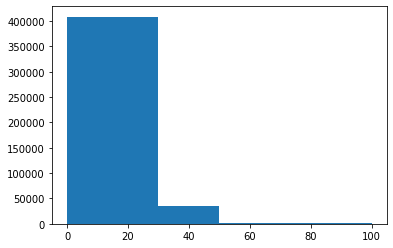

In [8]:
plt.hist(lens, bins=[0, 30, 50, 100])
print("Pixels with more than 50 ccds:", (lens > 50).sum())
print("Pixels with more than 100 ccds:", (lens > 100).sum())
print("Pixels with more than 500 ccds:", (lens > 500).sum())
print("Pixels with more than 1000 ccds:", (lens > 1000).sum())

In [14]:
ccd = CCD()

In [ ]:
ra0, dec0, ra1, dec1, ra2, dec2, ra3, dec3 = ccd.get_boundaries()



### Plotting the Pixel - CCD Relationship for the most populated pixel

In [ ]:
#Validating everything went as intended visually

NSIDE = 256
pixel_number = index_max
print(len(pixel2ccd_dict.keys()))

ccd = pixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)

pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()

In [ ]:
#Validating everything went as intended visually

NSIDE = 2048
pixel_number = index_max_sub
print(len(subpixel2ccd_dict.keys()))

ccd_sub = subpixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd_sub:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)


pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


## Preparing  Toy MultiSetSequence DataSet to avoid having to load all the massive dicts into the kernel and to avoid swapout

In [12]:
num_pixels = 2
num_subpixels = 4
max_ccds = 5
num_features = 9
#df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
#pixel_indices = random.sample(range(len(df_raw)), num_pixels)
pix_ids = [1,2]
pixel2subpixel_dict = {1:[11,12,13,14], 2:[21,22,23,24]}
subpixel2ccd_dict = {11:[111,112,113,114],12:[121,122,123,124,125], 13:[131,132,133,134,135], 14:[141,142,143,144,145],
                     21:[211,212,213,214,215],22:[221,222], 23:[231,232,233,234,235], 24:[241,242,243,244,245]}

In [ ]:
num_pixels = 1000
num_subpixels = 64
max_ccds = 30
num_features = 9
df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
pixel_indices = random.sample(range(len(df_raw)), num_pixels)

df = df_raw.iloc[pixel_indices]
pix_ids = df.pixel_id.to_numpy()

In [15]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no,ccd_no] = x[ccd_no]

Pixids [ 32169 341149 528957 280814 273264 694339 707785 370864  73820 257147
 721234 373321 240093 721951  78638 162768 293734 583417 502424 259217
  10623  54349 140162 691718 422984 607965  64748 390644 455119 656903
 110288 386137 626358 449543 724966 665073 370725 223104 393908 271923
 617217 717626 205244 510540  26423 101953 345996 458802 668096 288869
 145651 401565 683130 420478 691727 590342 567243 135094 106663 233370
 645883 197779 345088 123271 200933 106986 350064 622307 561085 204348
 152787 272232 186553 158774 636409 732350  77773 360436 389582 546558
 394931 255055 349046 392780 246970 140344 716785 113094 363394 464307
 286108  32732  48624 611997 180815 413295 640679  16138  82614 644876
   4038  10968  84809 320927 282221  47979 356212 251708 292991 255227
 242503 178668 299456 182238 586368  31363 276897 346143 330597 407139
 305569 417370 140455 210007 198626 384385 181416 177054 196818 592457
 170016 491636 462534 382966 299901  73788 223363  53306 731552 218627

In [16]:
var_set_len = True
lengths = np.zeros((num_pixels,num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 9  8  8 ... 13 13  9]
 [10  6  8 ... 10 10 13]
 [29 30 30 ... 29 29 30]
 ...
 [13 13 12 ... 11 12 11]
 [12  9 11 ...  9 10 11]
 [30 25 28 ... 28 29 29]]


In [19]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(1000,)
(1000, 64, 30, 9)
(1000, 64)


In [21]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

In [22]:
from collections import defaultdict
mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])

In [23]:
print(mini_multiset[483941])




[array([[[2.00000000e+00, 1.00000000e+00, 9.00000000e+01, ...,
         2.25054207e+01, 1.79983899e-02, 1.19000000e+02],
        [0.00000000e+00, 1.00000000e+00, 9.00000000e+01, ...,
         2.36905594e+01, 1.96362194e-02, 1.14000000e+02],
        [1.00000000e+00, 1.00000000e+00, 9.00000000e+01, ...,
         2.33807144e+01, 2.05958914e-02, 1.01000000e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.00000000e+00, 1.00000000e+00, 9.00000000e+01, ...,
         2.33807144e+01, 2.05958914e-02, 1.01000000e+02],
        [0.00000000e+00, 1.00000000e+00, 9.00000000e+01, ...,
         2.36454239e+01, 1.98624618e-02, 1.07000000e+02],
        [1.00000000e+00,

In [24]:


with open(f'../../bricks_data/mini_multiset.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()